In [1]:
import numpy as np
import os
import sys
os.environ["BACKEND"]   = "numpy"
script_dir              = os.path.dirname(os.curdir)
parent_dir              = os.path.abspath(os.path.join(script_dir, '..'))
parent_dir_up           = os.path.abspath(os.path.join(parent_dir, '..'))
if parent_dir_up not in sys.path:
    sys.path.append(parent_dir_up)

from QES.Algebra.hamil_quadratic import QuadraticSelection                          # to select the orbital indices
from QES.Algebra.Model.Noninteracting.Conserving.free_fermions import FreeFermions  # to generate the Hamiltonian
from QES.general_python.common.binary import extract as Extractor                   # to handle binary strings
from QES.general_python.common.binary import base2int, int2base, int2binstr         # to convert between binary strings and integers
from QES.general_python.physics import entropy as Entropy, density_matrix as Dens   # to calculate the entanglement entropy and density matrix
from QES.general_python.physics.sp import correlation_matrix as Corr                # to calculate the correlation matrix - single particle
from QES.general_python.common.flog import Logger                                   # to log the results
from QES.general_python.common.plot import Plotter                                  # to plot the results

# make random generator
rng     = np.random.default_rng(seed=42)
backend = 'numpy'
logger  = Logger(lvl = 'debug', use_ts_in_cmd=True)
logger.info('Starting the script')

INFO:general_python.algebra.utils:63: JAX backend available and successfully imported
INFO:general_python.algebra.utils:63: 	JAX 64-bit precision enabled.
INFO:general_python.algebra.utils:63: 	JAX is available but not set as the active backend.
INFO:general_python.algebra.utils:63: **************************************************
INFO:general_python.algebra.utils:63: Backend Configuration:
INFO:general_python.algebra.utils:63: 		NumPy Version: 1.26.4
INFO:general_python.algebra.utils:63: 		SciPy Version: 1.13.1
INFO:general_python.algebra.utils:63: 		JAX Version: 0.5.3
INFO:general_python.algebra.utils:63: 		Active Backend: numpy
INFO:general_python.algebra.utils:63: 			JAX Available: True
INFO:general_python.algebra.utils:63: 			Default Seed: 42
INFO:general_python.algebra.utils:63: 		NumPy Backend Details:
INFO:general_python.algebra.utils:63: 				Main Module: numpy
INFO:general_python.algebra.utils:63: 				Random Module: Generator
INFO:general_python.algebra.utils:63: 				SciPy M

05_05_2025_10-56_38 [INFO] Starting the script


Create the Free Fermion Hamiltonian

In [2]:
ns      = 12
t       = 1.0
backend = 'numpy'
hamil   = FreeFermions(ns=ns, t = t, dtype = np.complex128, backend = backend, logger=logger)
hamil

05_05_2025_10-56_38 [INFO] Log file created: ./log/global_05_05_2025_10-56_38.log
05_05_2025_10-56_38 [INFO] Log level set to: info
05_05_2025_10-56_38 [INFO] ############Global logger initialized.############


FreeFermions(ns=12, t=1.0, constant_offset=0.0)

### a) Plot the eigenenergies to see whether it is correct

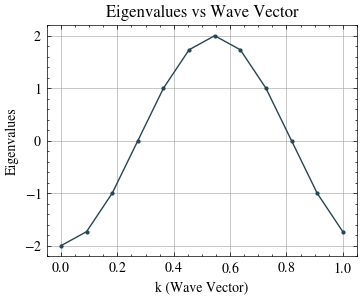

In [3]:
from QES.general_python.common.plot import Plotter

fig, ax = Plotter.get_subplots(1, 1, sizex=4, sizey=3)
k       = np.linspace(0, 2 * np.pi, hamil.ns)
ax[0].plot(k / 2 / np.pi, hamil.eig_val, '-o', markersize=2)
ax[0].set_xlabel('k (Wave Vector)')
ax[0].set_ylabel('Eigenvalues')
ax[0].set_title('Eigenvalues vs Wave Vector')
ax[0].grid(True)

### b) Test whether the many body energies agree

In [40]:
n_particles = 3
arange      = np.arange(hamil.ns)
energies    = []
nh          = 0
print(f"Total number should be: {2**ns}")
for i in range(hamil.ns + 1):
    # Calculate the number of combinations
    n_elements = QuadraticSelection.all_orbitals_size(hamil.ns, i)
    print(f"\tNumber of combinations for {i} particles: {n_elements}")
    
    # Generate all combinations of orbitals
    arange, all_combinations = QuadraticSelection.all_orbitals(arange, i)
    
    for orbitals in all_combinations:
        orbitals = np.array(orbitals)
        energy   = hamil.many_body_energy(orbitals)
        energies.append(energy)
    nh += n_elements
print(f"Total number of many-body states (nh): {nh}")


Total number should be: 4096
	Number of combinations for 0 particles: 1
	Number of combinations for 1 particles: 12
	Number of combinations for 2 particles: 66
	Number of combinations for 3 particles: 220
	Number of combinations for 4 particles: 495
	Number of combinations for 5 particles: 792
	Number of combinations for 6 particles: 924
	Number of combinations for 7 particles: 792
	Number of combinations for 8 particles: 495
	Number of combinations for 9 particles: 220
	Number of combinations for 10 particles: 66
	Number of combinations for 11 particles: 12
	Number of combinations for 12 particles: 1
Total number of many-body states (nh): 4096


### c) Plot the many body energies

Ground state energy: -7.4641016151377535
Sanity: Ground state energy = -7.4641016151377535, Ground state occupancy = 6


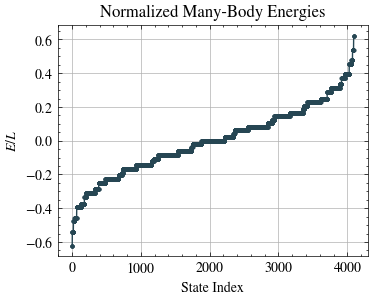

In [41]:
fig, ax = Plotter.get_subplots(1, 1, sizex=4, sizey=3)

# Sort and normalize the energies
energies_sorted     = np.sort(energies)
normalized_energies = energies_sorted / ns

# Plot the normalized energies
ax[0].plot(normalized_energies, '-o', markersize=2)
ax[0].set_xlabel('State Index')
ax[0].set_ylabel(r'$E / L$')
ax[0].set_title('Normalized Many-Body Energies')
ax[0].grid(True)

# Display the ground state energy
ground_state_energy = energies_sorted[0]
print(f"Ground state energy: {ground_state_energy}")

#! Sanity check
# Extract single-particle energies and identify negative ones
energies_sp         = hamil.eig_val
energies_sp_neg     = energies_sp[energies_sp < 0]

# Calculate the number of occupied states and the ground state energy
ground_state_occ    = len(energies_sp_neg)
ground_state        = np.sum(energies_sp_neg)

# Perform a sanity check to ensure consistency with the many-body ground state energy
assert np.isclose(ground_state, ground_state_energy), "Sanity check failed: Ground state energies do not match."
print(f"Sanity: Ground state energy = {ground_state}, Ground state occupancy = {ground_state_occ}")

### d) Test the state extractor

In [42]:
size        = ns
size_a      = 5
mask_a      = [0, 1, 3, 5, 8]
mask_a_e    = Extractor.prepare_mask(mask_a, size)

Extractor.test(size, size_a, mask_a_e, nsamples=3)

[INFO] State A mask = (3400) 110101001000
[INFO] State B mask = (695) 001010110111
[INFO] 
Full (2178)    = 100010000010
[INFO]   State A bits      = 00001
[INFO]   State B bits      = 0100010
[INFO]   A scalar-mask : 10000   [7.3 µs]
[INFO]   B scalar‑mask : 0100010   [6.2 µs]
[INFO]   A vector‑mask : 10000   [10.9 µs]
[INFO]   B vector‑mask : 0100010   [1.7 µs]
[INFO] ++++++++++++++++++++++++++++++++++++++++++++++++++

[INFO] 
Full (1947)    = 011110011011
[INFO]   State A bits      = 10110
[INFO]   State B bits      = 1101011
[INFO]   A scalar-mask : 01101   [4.9 µs]
[INFO]   B scalar‑mask : 1101011   [4.8 µs]
[INFO]   A vector‑mask : 01101   [8.0 µs]
[INFO]   B vector‑mask : 1101011   [3.2 µs]
[INFO] ++++++++++++++++++++++++++++++++++++++++++++++++++

[INFO] 
Full (2286)    = 100011101110
[INFO]   State A bits      = 11001
[INFO]   State B bits      = 0110110
[INFO]   A scalar-mask : 10011   [3.2 µs]
[INFO]   B scalar‑mask : 0110110   [3.7 µs]
[INFO]   A vector‑mask : 10011   [1.6 

### e) Reduced density matrix for a given state from the Hamiltonian

In [10]:
import time
import numpy as np

#! This script is used to test the performance of the correlation matrix and the many-body state
ns                      = 12
t                       = 1.0
backend                 = 'numpy'
hamil                   = FreeFermions(ns=ns, t = t, dtype = np.complex128, backend = backend, logger=logger)

# Number of samples to generate
num_samples             = 2
n_occupation            = 5
ordered                 = True

# Performance measurement
start_total             = time.time()

# Block 1: Mask preparation
dimA                    = 2**n_occupation
dimB                    = 2**(hamil.ns - n_occupation)

# Generate a random mask for the lattice positions
if ordered:
    mask_a              = np.arange(n_occupation)
else:
    mask_a              = np.sort(rng.choice(np.arange(hamil.ns), n_occupation, replace=False))
mask_b                  = np.setdiff1d(np.arange(hamil.ns), mask_a)
order                   = tuple(mask_a) + tuple(mask_b)
mask_a_extractor        = Extractor.make_extractor(mask_a, size=hamil.ns, backend='numba_vnb')
mask_b_extractor        = Extractor.make_extractor(mask_b, size=hamil.ns, backend='numba_vnb')
mask_a_onehot           = Extractor.to_one_hot(mask_a, hamil.ns)
mask_b_onehot           = Extractor.to_one_hot(mask_b, hamil.ns)

# test the extractor
state_to_extract        = rng.integers(0, 2**hamil.ns)
state_to_extract_str    = int2binstr(state_to_extract, hamil.ns)
state_to_extract_col    = Extractor.colorize_extractor(state_to_extract_str, mask_a, mask_b, logger)
state_ext_a             = mask_a_extractor(state_to_extract)
state_ext_b             = mask_b_extractor(state_to_extract)
start_block             = time.time()
logger.info(f"Mask for the lattice positions on A: {mask_a}", lvl=0)
logger.info(f"Mask for the lattice positions on A (one-hot): {mask_a_onehot}", lvl=1)
logger.info(f"Mask for the lattice positions on B: {mask_b}", lvl=0)
logger.info(f"Mask for the lattice positions on B (one-hot): {mask_b_onehot}", lvl=1)
logger.info(f"Order of the mask: {order}", lvl=1)
logger.title("Small test", desired_size=50, fill='+', color='green')
logger.info(f"State to extract: {state_to_extract}:{state_to_extract_col}", lvl=1)
logger.info(f"Mask for the lattice positions on A (extracted): {state_ext_a}:{int2binstr(state_ext_a, n_occupation)}", lvl=2, color='green')
logger.info(f"Mask for the lattice positions on B (extracted): {state_ext_b}:{int2binstr(state_ext_b, hamil.ns - n_occupation)}", lvl=2, color='white')
logger.info(f"Execution time: {time.time() - start_block:.4e} seconds", lvl=2)
logger.title("Finished", desired_size=50, fill='+', color='green')

# Initialize lists to store results
entropies_correlation   = []
entropies_many_body     = []

# Block 2: Transformation matrix preparation
start_block             = time.time()
W, W_A, W_A_CT          = hamil.prepare_transformation(mask_a_onehot)
logger.info(f"Shape of W: {W.shape}", lvl=2)
logger.info(f"Shape of W_A: {W_A.shape}", lvl=3)
logger.info(f"Shape of W_A_CT: {W_A_CT.shape}", lvl=3)
logger.info(f"Execution time: {time.time() - start_block:.4e} seconds", lvl=3, color = 'yellow')

for sample_idx in range(num_samples):
    logger.info(f"Processing sample {sample_idx + 1}/{num_samples}", lvl=1, color='red')
    many_body_state         = np.zeros((2**hamil.ns), dtype=np.complex128)

    # Block 3: Random orbital generation
    start_block             = time.time()
    arange, orb_4_mb_state  = QuadraticSelection.ran_orbitals(hamil.ns, n_occupation, rng=rng)
    orb_4_mb_state          = np.sort(orb_4_mb_state)
    orb_4_mb_state_1_hot    = Extractor.to_one_hot(orb_4_mb_state, hamil.ns)
    orb_4_mb_state_binary   = base2int(orb_4_mb_state_1_hot)
    logger.info(f"Randomly selected orbitals: {orb_4_mb_state}", lvl=2)
    logger.info(f"Randomly selected orbitals (one-hot): {orb_4_mb_state_1_hot}", lvl=3)
    logger.info(f"Randomly selected orbitals (int): {orb_4_mb_state_binary}", lvl=3)
    logger.info(f"Randomly selected orbitals (binary): {int2binstr(orb_4_mb_state_binary, hamil.ns)}", lvl=3)
    logger.info(f"Execution time: {time.time() - start_block:.4e} seconds", lvl=3, color = 'yellow')

    # Block 4: Correlation matrix calculation
    start_block             = time.time()
    correlation_matrix      = Corr.corr_single(W_A, orb_4_mb_state_1_hot, W_A_CT=W_A_CT, raw=True, subtract_identity=True)
    start_block_2           = time.time()
    corr_val, _             = np.linalg.eigh(correlation_matrix)
    entropy_correlation     = Entropy.entropy(corr_val, typek=Entropy.Entanglement.SINGLE)
    entropies_correlation.append(entropy_correlation)
    logger.info(f"Entropy from single-particle correlation: {entropy_correlation:.4e}", lvl=2, color='green')
    logger.info(f"Execution time: {time.time() - start_block:.4e} seconds", lvl=3, color='yellow')
    logger.info(f"Execution time for correlation matrix calculation: {start_block_2 - start_block:.4e} seconds", lvl=4, color='yellow')

    # Block 5: Many-body state and density matrix calculation
    start_block             = time.time()
    many_body_state         = hamil.many_body_state(orb_4_mb_state, resulting_state=many_body_state)
    start_block_2           = time.time()
    # red_dens_mat_schmidt, _ = Dens.schmidt_numba(many_body_state, dimA=dimA, dimB=dimB, eig=False)
    red_dens_mat_schmidt, _ = Dens.schmidt_numba_mask(psi = Dens.rho_numba_mask(many_body_state, order, n_occupation),
                                                    order = order, size_a = n_occupation, eig = True)
    entropy_many_body       = Entropy.entropy(red_dens_mat_schmidt, typek=Entropy.Entanglement.VN)
    entropies_many_body.append(entropy_many_body)
    logger.info(f"Entropy from many-body state: {entropy_many_body:.4e}", lvl=2, color='blue')
    logger.info(f"Execution time: {time.time() - start_block:.4e} seconds", lvl=3, color='yellow')
    logger.info(f"Execution time for many body state preparation: {start_block_2 - start_block:.4e} seconds", lvl=4, color='yellow')
    logger.info(f"Execution time for density matrix calculation: {time.time() - start_block_2:.4e} seconds", lvl=4, color='yellow')

    # Block 6: Check the difference between the two entropies
    diff_entropy            = np.abs(entropy_correlation - entropy_many_body)
    logger.info(f"Difference between entropies: {diff_entropy:.4e}", lvl=2, color='white')

logger.title("Finished", desired_size=50, fill='+', color='green')
logger.info(f"Total execution time: {time.time() - start_total:.4e} s : {(time.time() - start_total) / num_samples:.4e} s/S", lvl=0, color = 'red')

# Display summary statistics
logger.info(f"Average entropy from single-particle correlation: {np.mean(entropies_correlation):.4e}", lvl=0)
logger.info(f"Average entropy from many-body state: {np.mean(entropies_many_body):.4e}", lvl=0)


05_05_2025_10-56_48 [INFO] Mask for the lattice positions on A: [0 1 2 3 4]
05_05_2025_10-56_48 [INFO] 	->Mask for the lattice positions on A (one-hot): [ True  True  True  True  True False False False False False False False]
05_05_2025_10-56_48 [INFO] Mask for the lattice positions on B: [ 5  6  7  8  9 10 11]
05_05_2025_10-56_48 [INFO] 	->Mask for the lattice positions on B (one-hot): [False False False False False  True  True  True  True  True  True  True]
05_05_2025_10-56_48 [INFO] 	->Order of the mask: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
05_05_2025_10-56_48 [INFO] ++++++++++++++++++++Small test++++++++++++++++++++
05_05_2025_10-56_48 [INFO] 	->State to extract: 2290:100011110010
05_05_2025_10-56_48 [INFO] 		->Mask for the lattice positions on A (extracted): 17:10001
05_05_2025_10-56_48 [INFO] 		->Mask for the lattice positions on B (extracted): 114:1110010
05_05_2025_10-56_48 [INFO] 		->Execution time: 2.2104e-03 seconds
05_05_2025_10-56_48 [INFO] +++++++++++++++++++++Finished

### f) Try to generate a mixed state with a given entropy and try to minimize it.

In [11]:
#! This script is used to test the performance of the correlation matrix and the many-body state
ns                      = 12
nh                      = 2**ns
t                       = 1.0
hamil                   = FreeFermions(ns=ns, t=t, dtype=np.complex128, backend=backend, logger=logger)
n_occupation            = 5
f                       = n = n_occupation / hamil.ns

mask_d                  = QuadraticSelection.mask_orbitals(hamil.ns, n_occupation, ordered=True, rng=rng, return_b=True)
W, W_A, W_A_CT          = hamil.prepare_transformation(mask_d['mask_a_1h'])
page_value              = Entropy.EntropyPredictions.mean.page_u1_th(f=f, n=n, L=hamil.ns)
quadratic_chaotic       = Entropy.EntropyPredictions.mean.quadratic_chaotic(L=ns, f=f)

############################
many_body_energies      = hamil.many_body_energies(n_occupation, nh = nh)
sorted_energies         = sorted(many_body_energies.items(), key=lambda x: x[1])
binned_energies         = QuadraticSelection.bin_energies(sorted_energies, digits=12)

# energy manifolds
man_energies, man_energies_v = QuadraticSelection.man_energies(binned_energies, dtype=hamil.dtypeint)

##### Sanity checks

In [12]:
# Sanity checks
expected_states = QuadraticSelection.all_orbitals_size(hamil.ns, n_occupation)
logger.info(f"Number of many-body states (2^ns): {2**ns}", lvl=1)
logger.info(f"Number of many-body states: {len(sorted_energies)}", lvl=2, color='red')
logger.info(f"Number of many-body states in the U(1) symmetry sector: {expected_states}", lvl=2, color='blue')
assert len(sorted_energies) == expected_states, "Mismatch in the total number of many-body states!"

# Validate energy values
unique_energies     = set(energy for _, energy in sorted_energies)
unique_energies_len = len(unique_energies)
binned_energies_len = len(binned_energies)
logger.info(f"Number of unique energy levels in sorted_energies: {unique_energies_len}", lvl=1)
logger.info(f"Number of unique energy levels in bins: {binned_energies_len} (12 digits cut)", lvl=1)
# assert len(unique_energies) == binned_energies_len, "Mismatch in the number of unique energy levels!"

# Verify energy manifold counts
manifold_counts = sum(man_energies.values())
logger.info(f"Total states across energy manifolds: {manifold_counts}", lvl=1)
assert manifold_counts == len(sorted_energies), "Mismatch in the total states across energy manifolds!"

# Check if the energy values in `sorted_energies` match `many_body_energies`
for state, energy in sorted_energies:
    assert np.isclose(many_body_energies[state], energy), f"Energy mismatch for state {state}!"
logger.info("All energy values match between `sorted_energies` and `many_body_energies`.", lvl=1)
logger.info("Sanity checks passed successfully!", lvl=0, color='green')

05_05_2025_10-57_41 [INFO] 	->Number of many-body states (2^ns): 4096
05_05_2025_10-57_41 [INFO] 		->Number of many-body states: 792
05_05_2025_10-57_41 [INFO] 		->Number of many-body states in the U(1) symmetry sector: 792
05_05_2025_10-57_41 [INFO] 	->Number of unique energy levels in sorted_energies: 344
05_05_2025_10-57_41 [INFO] 	->Number of unique energy levels in bins: 45 (12 digits cut)
05_05_2025_10-57_41 [INFO] 	->Total states across energy manifolds: 792
05_05_2025_10-57_41 [INFO] 	->All energy values match between `sorted_energies` and `many_body_energies`.
05_05_2025_10-57_41 [INFO] Sanity checks passed successfully!


##### Selection

In [13]:
gamma               = rng.choice(man_energies_v, size=1)[0]
order               = mask_d['order']
manifolds_limit     = [x for x in man_energies if man_energies[x] == gamma]
manifolds_choice    = rng.choice(manifolds_limit, size=1)[0]
logger.info(f"Randomly selected energy manifold: {gamma}", lvl=0)
logger.info(f"Randomly selected energy manifold energies: {manifolds_limit}", lvl=0)
logger.info(f"Randomly selected energy manifold: {manifolds_choice}", lvl=0)
logger.info(f"Those are the states: {binned_energies[manifolds_choice]}", lvl=0)

# at this energy, we have gamma degenerate states, check their single particle entropy
# and many body entropy
entropies_sp_np     = np.zeros((gamma), dtype=np.float64)
entropies_mb_np     = np.zeros((gamma), dtype=np.float64)
energies_np         = np.zeros((gamma), dtype=np.float64)
psi_np              = np.zeros((nh, gamma), dtype=np.complex128)
compute_mb_state    = ns < 14
states_in_bin       = binned_energies[manifolds_choice]

for ii, state in enumerate(states_in_bin):
    
    #! occupied orbitals
    if isinstance(state, int):
        occ_orb = int2base(state, ns, spin=False, spin_value=1).astype(hamil._dtypeint)
        occ_idx = np.flatnonzero(occ_orb)
    else:
        occ_idx = state

    #! energy - sanity check
    energy              = hamil.many_body_energy(occ_idx)
    energies_np[ii]     = energy
    
    #! correlation matrix
    corr_mat            = Corr.corr_single(W_A, occ_idx, W_A_CT=W_A_CT, raw=True, subtract_identity=True)
    eigvals             = np.linalg.eigvalsh(corr_mat)
    entropies_sp_np[ii] = Entropy.entropy(eigvals, typek=Entropy.Entanglement.SINGLE)
    
    #! many body state
    if compute_mb_state:
        mb_state            = hamil.many_body_state(occ_idx)
        rho                 = Dens.rho_numba_mask(mb_state, order, n_occupation)
        schmidt_vals, _     = Dens.schmidt_numba_mask(psi=rho, order=order, size_a=n_occupation, eig=False)
        entropies_mb_np[ii] = Entropy.entropy(schmidt_vals, typek=Entropy.Entanglement.VN)
        psi_np[:, ii]       = mb_state

for i in range(gamma):
    logger.info(f"State {i}: {states_in_bin[i]} - energy (sanity) = {energies_np[i]}", lvl=1)
    logger.info(f"Entropy from single-particle correlation: {entropies_sp_np[i]:.4e}", lvl=3, color='green')
    logger.info(f"Entropy from many-body state: {entropies_mb_np[i]:.4e}", lvl=3, color='blue')
    logger.info(f"Difference between entropies: {abs(entropies_sp_np[i] - entropies_mb_np[i]):.4e}", lvl=4, color='white')
    

05_05_2025_10-57_43 [INFO] Randomly selected energy manifold: 7
05_05_2025_10-57_43 [INFO] Randomly selected energy manifold energies: [-5.464101615138, -1.464101615138, 1.464101615138, 5.464101615138]
05_05_2025_10-57_43 [INFO] Randomly selected energy manifold: -1.464101615138
05_05_2025_10-57_43 [INFO] Those are the states: [1697, 1317, 1417, 1577, 1165, 1187, 1067]
05_05_2025_10-57_43 [INFO] 	->State 0: 1697 - energy (sanity) = -1.4641016151377548
05_05_2025_10-57_43 [INFO] 			->Entropy from single-particle correlation: 2.6765e+00
05_05_2025_10-57_43 [INFO] 			->Entropy from many-body state: 2.6765e+00
05_05_2025_10-57_43 [INFO] 				->Difference between entropies: 4.4409e-16
05_05_2025_10-57_43 [INFO] 	->State 1: 1317 - energy (sanity) = -1.464101615137754
05_05_2025_10-57_43 [INFO] 			->Entropy from single-particle correlation: 3.1485e+00
05_05_2025_10-57_43 [INFO] 			->Entropy from many-body state: 3.1485e+00
05_05_2025_10-57_43 [INFO] 				->Difference between entropies: 4.4409e-

##### JAX calculations

In [16]:
import jax.numpy as jnp
import jax

psi_jnp         = jnp.array(psi_np, dtype=jnp.complex128)
U_org           = jnp.array(QuadraticSelection.haar_random_unitary(gamma, rng=rng, dtype=np.complex128), dtype=jnp.complex128)
psi_mixed       = psi_jnp @ U_org.T

entro_org_jax   = jnp.zeros((gamma), dtype=jnp.float64)
entro_mixed_jax = jnp.zeros((gamma), dtype=jnp.float64)
normlog         = n_occupation * jnp.log(2.0)

logger.info("Mixing the states", lvl=1)
# Compute entropies for mixed and original states
for i in range(gamma):
    # mixed state
    rho_mixed              = Dens.jnp.rho_mask(psi_mixed[:, i], order, n_occupation)
    schmidt_mixed, _       = Dens.jnp.schmidt_mask(rho_mixed, order, n_occupation, eig=False)
    entro_mixed_jax        = entro_mixed_jax.at[i].set(Entropy.jnp.vn_entropy(schmidt_mixed) / normlog)

    # original state
    rho_orig               = Dens.jnp.rho_mask(psi_jnp[:, i], order, n_occupation)
    schmidt_orig, _        = Dens.jnp.schmidt_mask(rho_orig, order, n_occupation, eig=False)
    entro_org_jax          = entro_org_jax.at[i].set(Entropy.jnp.vn_entropy(schmidt_orig) / normlog)

org_average_entropy = jnp.mean(entro_org_jax)
# mixed and original entropies
logger.info(f"Page value: {page_value/normlog}", lvl=1, color='yellow')
logger.info(f"Quadratic chaotic value: {quadratic_chaotic/normlog}", lvl=1, color='yellow')
logger.info(f"Entropy is normalized by: {normlog}", lvl=2, color='yellow')
logger.info(f"Non-jax (original): {entropies_mb_np / np.array(normlog)}", lvl=1, color='green')
logger.info(f"JAX:", lvl=0, color='white')
logger.info(f"Entropy from mixed state (jax): {entro_mixed_jax}", lvl=1, color='red')
logger.info(f"Minimum entropy (mixed): {jnp.min(entro_mixed_jax):.4e}", lvl=2, color='red')
logger.info(f"Maximum entropy (mixed): {jnp.max(entro_mixed_jax):.4e}", lvl=2, color='red')
logger.info(f"Average entropy (mixed): {jnp.mean(entro_mixed_jax):.4e}", lvl=2, color='red')
logger.info(f"Entropy from original state (jax): {entro_org_jax}", lvl=1, color='blue')
logger.info(f"Minimum entropy (original): {jnp.min(entro_org_jax):.4e}", lvl=2, color='blue')
logger.info(f"Maximum entropy (original): {jnp.max(entro_org_jax):.4e}", lvl=2, color='blue')
logger.info(f"Average entropy (original): {jnp.mean(entro_org_jax):.4e}", lvl=2, color='blue')


05_05_2025_10-58_29 [INFO] 	->Mixing the states


05_05_2025_10-58_29 [INFO] 	->Page value: 0.9622202921551711
05_05_2025_10-58_29 [INFO] 	->Quadratic chaotic value: 0.6459555692400096
05_05_2025_10-58_29 [INFO] 		->Entropy is normalized by: 3.4657359027997265
05_05_2025_10-58_29 [INFO] 	->Non-jax (original): [0.7722758  0.90845155 0.78541998 0.79041192 0.78541998 0.79041192
 0.7722758 ]
05_05_2025_10-58_29 [INFO] JAX:
05_05_2025_10-58_29 [INFO] 	->Entropy from mixed state (jax): [0.86158715 0.88306344 0.83589322 0.86651628 0.86867528 0.88873806
 0.88411745]
05_05_2025_10-58_29 [INFO] 		->Minimum entropy (mixed): 8.3589e-01
05_05_2025_10-58_29 [INFO] 		->Maximum entropy (mixed): 8.8874e-01
05_05_2025_10-58_29 [INFO] 		->Average entropy (mixed): 8.6980e-01
05_05_2025_10-58_29 [INFO] 	->Entropy from original state (jax): [0.7722758  0.90845155 0.78541998 0.79041192 0.78541998 0.79041192
 0.7722758 ]
05_05_2025_10-58_29 [INFO] 		->Minimum entropy (original): 7.7228e-01
05_05_2025_10-58_29 [INFO] 		->Maximum entropy (original): 9.0845e-01

In [17]:
import jax
import jax.numpy as jnp
import optax
from functools import partial

#! Unitary from arbitrary Z
@jax.jit
def unitary_from_Z(Z: jnp.ndarray) -> jnp.ndarray:
    Q, R   = jnp.linalg.qr(Z)
    phase  = jnp.diag(R)
    phase /= jnp.where(jnp.abs(phase) < 1e-20, 1.0, jnp.abs(phase))
    Q      = Q @ jnp.diag(jnp.conj(phase))
    return Q

#! Initialization
def init_params(key, gamma: int, dtype=jnp.complex128) -> jnp.ndarray:
    key_re, key_im  = jax.random.split(key)
    re              = jax.random.normal(key_re, (gamma, gamma))
    im              = jax.random.normal(key_im, (gamma, gamma))
    return (re + 1j * im).astype(dtype)

def init_coeff(key, gamma: int, dtype=jnp.complex128) -> jnp.ndarray:
    key_re, key_im  = jax.random.split(key)
    re              = jax.random.normal(key_re, (gamma, 1))
    im              = jax.random.normal(key_im, (gamma, 1))
    return (re + 1j * im).astype(dtype)

#! Forward Pass
def forward(Z: jnp.ndarray, mode='a') -> jnp.ndarray:
    U = unitary_from_Z(Z)
    if mode == 'U':
        return U
    coeffs = jnp.ones(U.shape[0], dtype=U.dtype) / jnp.sqrt(U.shape[0])
    return U @ coeffs

#! Mean Entropy Loss
@partial(jax.jit, static_argnames=('order', 'size_a', 'use_a'))
def mean_entropy_loss(Z         : jnp.ndarray,
                    psi_mixed   : jnp.ndarray,
                    order       : tuple,
                    size_a      : int,
                    use_a       : bool) -> float:
    """
    Two pathways:
    - `use_a = True`    : Optimize over superposition vector a (shape gamma \times 1)
    - `use_a = False`   : Optimize over U ∈ U(gamma)
    """
    normlog = size_a * jnp.log(2.0)
    normst  = jnp.sqrt(gamma)

    def loss_a_path(Z, psi_mixed):
        a               = Z / normst
        psi_combined    = psi_mixed @ a                     # D \times 1
        rho             = Dens.jnp.rho_mask(psi_combined, order, size_a)
        lam, _          = Dens.jnp.schmidt_mask(rho, order, size_a, eig=False)
        return Entropy.jnp.vn_entropy(lam) / normlog

    def loss_U_path(Z, psi_mixed):
        """
        Loss function: average von Neumann entropy of reduced states after applying unitary U(Z) to psi_mixed.
        
        Parameters
        ----------
        Z : array
            Parametrization of unitary matrix (e.g., via exponential map).
        psi_mixed : array, shape (D, gamma)
            Mixed state represented as a matrix with gamma basis states over D samples.

        Returns
        -------
        mean_entropy : float
            Average entropy across all transformed states.
        """
        U           = unitary_from_Z(Z)     # gamma  \times  gamma unitary
        psi_new     = psi_mixed @ U         # D  \times  gamma transformed states
        def S_single(state):
            rho     = Dens.jnp.rho_mask(state, order, size_a)
            lam, _  = Dens.jnp.schmidt_mask(rho, order, size_a, eig=False)
            return Entropy.jnp.vn_entropy(lam) / normlog
        return jnp.mean(jax.vmap(S_single)(psi_new.T))
    if use_a:
        loss_in = loss_a_path(Z, psi_mixed)
    else:
        loss_in = loss_U_path(Z, psi_mixed)
    return loss_in
    # return jax.lax.cond(use_a, loss_a_path, loss_U_path, Z, psi_mixed)

#! Training Loop
def train_mean_entropy(psi_mixed    : jnp.ndarray,
                    order           : tuple,
                    size_a          : int,
                    steps           : int   = 4000,
                    lr              : float = 3e-3,
                    log_every       : int   = 400,
                    use_a           : bool  = False,
                    seed            : int   = 0):
    gamma       = psi_mixed.shape[1]
    key         = jax.random.PRNGKey(seed)

    # Init parameters
    Z           = init_coeff(key, gamma) if use_a else init_params(key, gamma)

    # Optax setup
    opt         = optax.adam(lr)
    opt_state   = opt.init(Z)

    @jax.jit
    def step(Z, opt_state):
        loss, grad          = jax.value_and_grad(mean_entropy_loss)(Z, psi_mixed, order, size_a, use_a)
        updates, opt_state  = opt.update(grad, opt_state, Z)
        Z                   = optax.apply_updates(Z, updates)
        return Z, opt_state, loss

    # Training loop
    history = []
    for t in range(steps + 1):
        Z, opt_state, loss = step(Z, opt_state)
        history.append(loss)
        if t % log_every == 0:
            print(f"[step {t:5d}]   ⟨S_A⟩ = {loss:.6e}")

    return Z, jnp.array(history)


##### Use just coefficients

In [18]:
size_a      = n_occupation
Z_opt, h    = train_mean_entropy(psi_mixed, order, size_a, steps=25000, lr=1, use_a=True)
U_opt       = unitary_from_Z(Z_opt)                 # gamma  \times  gamma exact unitary
states      = psi_mixed @ U_opt                     # D  \times  gamma

[step     0]   ⟨S_A⟩ = 8.782887e-01
[step   400]   ⟨S_A⟩ = 8.804551e-01
[step   800]   ⟨S_A⟩ = 8.883504e-01
[step  1200]   ⟨S_A⟩ = 8.896525e-01
[step  1600]   ⟨S_A⟩ = 8.894437e-01
[step  2000]   ⟨S_A⟩ = 8.886457e-01
[step  2400]   ⟨S_A⟩ = 8.874596e-01
[step  2800]   ⟨S_A⟩ = 8.858532e-01
[step  3200]   ⟨S_A⟩ = 8.836603e-01
[step  3600]   ⟨S_A⟩ = 8.805941e-01
[step  4000]   ⟨S_A⟩ = 8.763231e-01
[step  4400]   ⟨S_A⟩ = 8.709452e-01
[step  4800]   ⟨S_A⟩ = 8.664941e-01
[step  5200]   ⟨S_A⟩ = 8.677462e-01
[step  5600]   ⟨S_A⟩ = 8.797605e-01
[step  6000]   ⟨S_A⟩ = 8.968332e-01
[step  6400]   ⟨S_A⟩ = 8.934031e-01
[step  6800]   ⟨S_A⟩ = 8.907638e-01
[step  7200]   ⟨S_A⟩ = 8.774690e-01
[step  7600]   ⟨S_A⟩ = 8.331149e-01
[step  8000]   ⟨S_A⟩ = 8.354582e-01
[step  8400]   ⟨S_A⟩ = 8.402862e-01
[step  8800]   ⟨S_A⟩ = 8.408669e-01
[step  9200]   ⟨S_A⟩ = 8.407655e-01
[step  9600]   ⟨S_A⟩ = 8.408357e-01
[step 10000]   ⟨S_A⟩ = 8.411920e-01
[step 10400]   ⟨S_A⟩ = 8.417771e-01
[step 10800]   ⟨S_A⟩ = 8.425

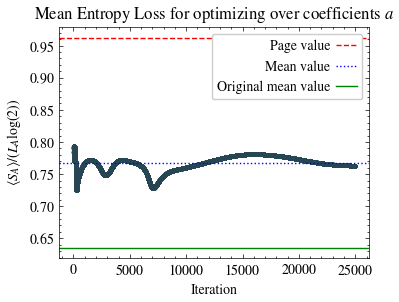

In [22]:
fig, ax     = Plotter.get_subplots(1, 1, sizex=4, sizey=3)
ax[0].plot(h, 'o', markersize=2)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(r'$\langle S_A \rangle / (L_A\log(2))$')
ax[0].axhline(page_value/normlog, color='red', linestyle='--', label='Page value')
ax[0].axhline(jnp.mean(h), color='blue', linestyle=':', label='Mean value')
ax[0].axhline(org_average_entropy, color='green', linestyle='-', label='Original mean value')
ax[0].set_title('Mean Entropy Loss for optimizing over coefficients $a$')
Plotter.set_legend(ax[0], frameon=True)

##### Use a whole unitary

In [23]:
size_a      = n_occupation
Z_opt, h    = train_mean_entropy(psi_mixed, order, size_a, steps=7000, lr=1e-1, use_a=False)
U_opt       = unitary_from_Z(Z_opt)                 # gamma  \times  gamma exact unitary
states      = psi_mixed @ U_opt                     # D  \times  gamma

[step     0]   ⟨S_A⟩ = 7.672869e-01
[step   400]   ⟨S_A⟩ = 7.651661e-01
[step   800]   ⟨S_A⟩ = 7.642952e-01
[step  1200]   ⟨S_A⟩ = 7.642401e-01
[step  1600]   ⟨S_A⟩ = 7.618587e-01
[step  2000]   ⟨S_A⟩ = 7.617599e-01
[step  2400]   ⟨S_A⟩ = 7.618430e-01
[step  2800]   ⟨S_A⟩ = 7.609768e-01
[step  3200]   ⟨S_A⟩ = 7.633861e-01
[step  3600]   ⟨S_A⟩ = 7.670883e-01
[step  4000]   ⟨S_A⟩ = 7.709394e-01
[step  4400]   ⟨S_A⟩ = 7.724488e-01
[step  4800]   ⟨S_A⟩ = 7.746819e-01
[step  5200]   ⟨S_A⟩ = 7.737097e-01
[step  5600]   ⟨S_A⟩ = 7.660608e-01
[step  6000]   ⟨S_A⟩ = 7.615682e-01
[step  6400]   ⟨S_A⟩ = 7.633672e-01
[step  6800]   ⟨S_A⟩ = 7.684939e-01


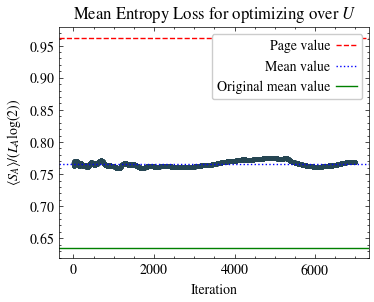

In [24]:
fig, ax     = Plotter.get_subplots(1, 1, sizex=4, sizey=3)
ax[0].plot(h, 'o', markersize=2)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel(r'$\langle S_A \rangle / (L_A\log(2))$')
ax[0].axhline(page_value/normlog, color='red', linestyle='--', label='Page value')
ax[0].axhline(jnp.mean(h), color='blue', linestyle=':', label='Mean value')
ax[0].axhline(org_average_entropy, color='green', linestyle='-', label='Original mean value')
ax[0].set_title('Mean Entropy Loss for optimizing over $U$')
Plotter.set_legend(ax[0], frameon=True)

##### Autoencoder - doesn't work, don't even run



In [ ]:
import jax
import jax.numpy as jnp
from functools import partial
import optax

# -- Utilities --
@jax.jit
def unitary_from_Z(Z):
    Q, R   = jnp.linalg.qr(Z)
    phase  = jnp.diag(R) / jnp.where(
                jnp.abs(jnp.diag(R)) < 1e-20, 1.0, jnp.abs(jnp.diag(R)))
    Q      = Q @ jnp.diag(jnp.conj(phase))
    return Q

def init_unitary_params(key, gamma):
    re, key = jax.random.normal(key, (gamma, gamma)), jax.random.split(key)[0]
    im, key = jax.random.normal(key, (gamma, gamma)), jax.random.split(key)[0]
    return (re + 1j * im)

# -- Entropy computation --
def entropy_single(state, order, size_a, normlog):
    rho        = Dens.jnp.rho_mask(state, order, size_a)
    schmidt, _ = Dens.jnp.schmidt_mask(rho, order, size_a, eig=False)
    return Entropy.jnp.vn_entropy(schmidt) / normlog

# -- Forward pass through layered unitary autoencoder --
def stacked_unitary(Zs):
    U = unitary_from_Z(Zs[0])
    for Z in Zs[1:]:
        U = unitary_from_Z(Z) @ U
    return U

@partial(jax.jit, static_argnums=(2, 3, 4))
def autoencoder_loss(Zs, psi_input, order, size_a, num_layers):
    normlog = size_a * jnp.log(2.0)
    U       = stacked_unitary(Zs)
    U_dag   = U.conj().T

    encoded     = U @ psi_input     # gamma  \times  D
    decoded     = U_dag @ encoded   # gamma  \times  D

    reconstruction_loss = jnp.mean(jnp.abs(decoded - psi_input)**2)

    # Apply entropy to each column of encoded
    encoded_T   = encoded.T  # shape D  \times  gamma
    entropies   = jax.vmap(lambda x: entropy_single(x, order, size_a, normlog))(encoded_T)
    entropy_reg = jnp.mean(entropies)

    return reconstruction_loss + entropy_reg  # total loss

# -- Training loop with multiple unitary layers --
def train_autoencoder(psi_input, order, size_a, steps=4000, lr=3e-3, log_every=400, seed=0, num_layers=2):
    gamma    = psi_input.shape[0]
    key      = jax.random.PRNGKey(seed)
    normlog  = size_a * jnp.log(2.0)

    # Initialize a list of parameters for stacked unitaries
    keys     = jax.random.split(key, num_layers)
    Zs       = [init_unitary_params(k, gamma) for k in keys]

    opt      = optax.adam(lr)
    opt_state = opt.init(Zs)

    @jax.jit
    def step(Zs, opt_state):
        loss, grads      = jax.value_and_grad(autoencoder_loss)(Zs, psi_input, order, size_a, num_layers)
        updates, opt_state = opt.update(grads, opt_state, params=Zs)
        Zs = optax.apply_updates(Zs, updates)
        return Zs, opt_state, loss

    history = []
    for t in range(steps + 1):
        Zs, opt_state, L = step(Zs, opt_state)
        history.append(L)
        if t % log_every == 0:
            print(f"Step {t:5d} | Loss = {L:.6e}")

    return Zs, history


In [ ]:
size_a      = n_occupation
Z_opt, h    = train_autoencoder(psi_mixed, order, size_a, steps=70, lr=1e-1, log_every=10, seed=0, num_layers=1)
U_opt       = unitary_from_Z(Z_opt)                 # gamma  \times  gamma exact unitary
states      = psi_mixed @ U_opt                     # D  \times  gamma

Step     0 | Loss = 9.643953e-01


In [18]:
ns          = 6
site        = 2
shift       = ns - site

mask_shift  = 1 << shift
print(f"mask_shift: {mask_shift:0{ns}b}")
mask_rev    = mask_shift - 1
print(f"mask_rev: {mask_rev:0{ns}b}")
mask_bits   = mask_rev << (site)
print(f"mask_bits: {mask_bits:0{ns}b}")

mask_shift: 010000
mask_rev: 001111
mask_bits: 111100
